In [1]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport NV_generator
figures_path = "../../../Writing/Thesis/Figures/"

In [2]:
# Constants
delta = 2 * np.pi * 2.88 * 10 ** 9 # zero field splitting is 2.88 GHz in real frequency
B_field = 0.0403555 # Teslas
gam_el = -1.760859 * 10 ** 11 # Gyromagnetic ratio for a single electron in rad s-1 T-1
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
hbar = 1.05457173 * 10 ** (-34)
h = hbar * 2 * np.pi
mu0 = 4 * np.pi * 10 ** (-7)
omega_larmor = -1 * gam_c * B_field

In [3]:
# Position of spin
if False: # change to true to get a new spin
    A_list, B_list, r_list, costheta_list, sintheta_list = NV_generator.generate_spins(25)
    A, B, r, costheta, sintheta = A_list[0], B_list[0], r_list[0], costheta_list[0], sintheta_list[0]
    print A, B, r, costheta, sintheta

In [4]:
A, B, r, costheta, sintheta = 59891.5741878, 610776.610967, 6.67885843539e-10, 0.617213399848, 0.786795792469
print A/(2 * np.pi * 1e3), B/(2 * np.pi * 1e3), r

9.53204008154 97.2081167603 6.67885843539e-10


In [5]:
# Spin 1 operators for NV center
Si = qt.qeye(3)
Sx = qt.jmat(1, 'x')
Sy = qt.jmat(1, 'y')
Sz = qt.jmat(1, 'z')

# Spin 1/2 matrices for c13
Ii = qt.qeye(2)
Ix = qt.jmat(.5, 'x')
Iy = qt.jmat(.5, 'y')
Iz = qt.jmat(.5, 'z')

In [6]:
# Hamiltonians in angular frequency units
H_zf = qt.tensor(delta * Sz ** 2, Ii) # zero field splitting of NV spin
H_SB = qt.tensor(-1 * gam_el * B_field * Sz, Ii) # interaction of NV spin with B field (assumed along z direction)
H_IB = qt.tensor(Si, -1 * gam_c * B_field * Iz) # interaction of c13 spin with B field
hyperfine_prefactor = -1 * mu0 * gam_el * gam_c * hbar/(4 * np.pi * r ** 3) # prefactor for hyperfine (dipole-dipole) interaction
S_dot_r = Sx * sintheta + Sz * costheta
I_dot_r = Ix * sintheta + Iz * costheta
S_dot_I = qt.tensor(Sx, Ix) + qt.tensor(Sy, Iy) + qt.tensor(Sz, Iz)
H_hf_full = hyperfine_prefactor * (3 * qt.tensor(S_dot_r, I_dot_r) - S_dot_I) # hyperfine (dipole-dipole) interaction
H_full = H_zf + H_SB + H_IB + H_hf_full # full hamiltonian
H_rot = H_zf + H_IB + H_hf_full
H_rot_nozf = H_IB + H_hf_full
S_dot_r_sec = Sz * costheta
S_dot_I_sec = qt.tensor(Sz, Iz)
H_hf_sec = hyperfine_prefactor * (3 * qt.tensor(S_dot_r_sec, I_dot_r) - S_dot_I_sec)
H_sec = H_zf + H_SB + H_IB + H_hf_sec # secular hamiltonian
H_sec_rot = H_zf + H_IB + H_hf_sec # secular hamiltonian in rotating frame
H_approx = H_IB + H_hf_sec # hamiltonian used in paper

In [7]:
print -1 * gam_el * B_field/(2 * np.pi * 1e9)
k_b = 1.38064852 * 1e-23
print gam_c * .05 * hbar/k_b

1.13096052242
2.56881467932e-05


In [8]:
# Pulse sequence parameters
N = 64
tau = analysis.choose_tau_params(N)

In [9]:
# Pi pulse on NV spin between ms = 0 and ms = 1 states
# I'm still assuming this is "infinitely" fast, only involves the NV, and is a complete population inversion
# because I don't know what hamiltonian to use realistically for the microwave field
Sz0, Sz1 = qt.basis(3, 1), qt.basis(3,0)
Sz_sigmax = Sz0 * Sz1.dag() + Sz1 * Sz0.dag()
pi_pulse = qt.tensor(-1j * Sz_sigmax, Ii)
Sz_sigmax, pi_pulse

(Quantum object: dims = [[3], [3]], shape = [3, 3], type = oper, isherm = True
 Qobj data =
 [[ 0.  1.  0.]
  [ 1.  0.  0.]
  [ 0.  0.  0.]],
 Quantum object: dims = [[3, 2], [3, 2]], shape = [6, 6], type = oper, isherm = False
 Qobj data =
 [[ 0.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j]
  [ 0.+0.j  0.+0.j  0.+0.j  0.-1.j  0.+0.j  0.+0.j]
  [ 0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
  [ 0.+0.j  0.-1.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
  [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
  [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]])

In [10]:
# Initial density matrix
# the NV starts in the plus x state and the spin is fully disordered
rho_init = qt.tensor(qt.ket2dm((Sz0 + Sz1).unit()), .5 * Ii)
rho_init

Quantum object: dims = [[3, 2], [3, 2]], shape = [6, 6], type = oper, isherm = True
Qobj data =
[[ 0.25  0.    0.25  0.    0.    0.  ]
 [ 0.    0.25  0.    0.25  0.    0.  ]
 [ 0.25  0.    0.25  0.    0.    0.  ]
 [ 0.    0.25  0.    0.25  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.  ]]

In [11]:
H = H_full
P = np.zeros(len(tau))
for ind in range(len(tau)):
    t = tau[ind]
    U_tau = (-1j * t * H).expm()
    U = (U_tau * pi_pulse * U_tau) ** N
    rho_final = U * rho_init * U.dag()
    P[ind] = (2 * rho_init * rho_final).tr().real
    if P[ind] < .9 and False:
        print "rho_final: ", rho_final.ptrace(0)
        print "rho_final eigenvalues: ", rho_final.ptrace(0).eigenenergies()
        print "P: ", P[ind]
        print "\n \n"
M = 2 * P - 1

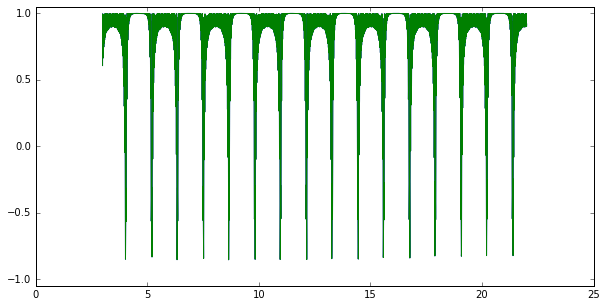

In [13]:
%matplotlib inline
inds = np.arange(len(tau))
fig, ax = analysis.initialize_data_plot()
ax.plot(tau[inds] * 1e6, M[inds])
ax.plot(tau[inds] * 1e6, analysis.calc_M_single(A, B, N, omega_larmor, tau[inds]))

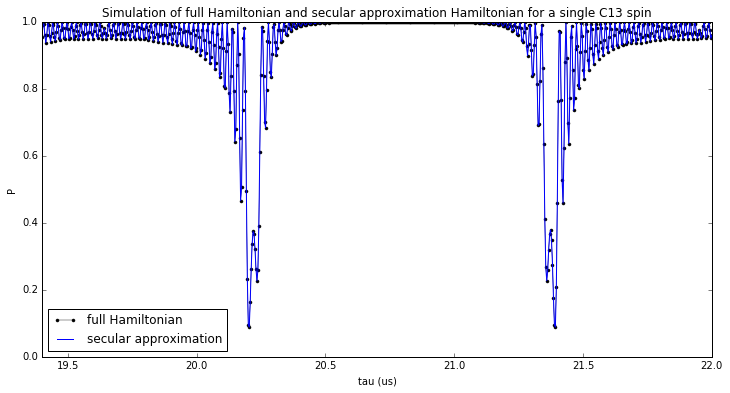

In [14]:
%matplotlib inline
fig,ax = analysis.initialize_data_plot(figsize = (12,6), xlims = [19.4,22], ylims = [0,1])
ax.set_xlabel('tau (us)')
ax.set_ylabel('P')
ax.plot(tau * 1e6, P, '.-k', lw=0.4, label = 'full Hamiltonian')
secular_approx_P = .5 * (1+analysis.calc_M_single(A, B, N, omega_larmor, tau))
ax.plot(tau * 1e6, secular_approx_P, label = 'secular approximation')
plt.title("Simulation of full Hamiltonian and secular approximation Hamiltonian for a single C13 spin")
plt.legend(loc = 3)
#plt.savefig(figures_path + "QuTiP/dynamical_decoupling_19p4_22us_N64_ms1")

In [15]:
displayed_inds = np.where(tau>=19.5*1e-6)[0]
print len(displayed_inds), np.mean(np.abs((P[displayed_inds] - secular_approx_P[displayed_inds])))

671 7.50364134871e-06


In [19]:
displayed_inds[np.argmin(P[displayed_inds])]

4936

### Zero-field splitting and rotating frame don't change the answer at all. The secular approximation doesn't seem to either! Wow! The fact that it doesn't change anything actually remains true even with delta = 0, i.e. it's not because of the "large zero-field splitting".
### If you get rid of the hyperfine coupling, the signal goes away completely, and same for the B field term for the c13.
### The terms in the final density matrix for spin -1 are on the order of 10^(-9)!

### I'm curious what happens if you don't have the pi pulses at all!
### Are the different hamiltonians different then?
### With the full hamiltonian, if you have a whole bath of spins, what happens to the NV center when you trace out the environment? Can this show me T1 and T2? Decoherence? Can it accurately predict measured decoherence times?
### Understand why the secular approximation is so good. Is it dynamic decoupling?

### Very interestingly, H_rot is good but H_rot_nozf is not!

# Here's the answer:
### the full hamiltonian is correct, and also remains correct without the zero field splitting *or* the SB coupling, but if you remove both, it's incorrect unless you also take the secular approximation for the coupling!
### The correct secular approximation is that H_ZF and H_SB are *big* and the other things are *small*, therefore S_z is conserved to a good approximation. Since S_x and S_y don't commute with S_z you can get rid of them.

In [38]:
H = H_approx 
rho_nv = []
rho_init_nv_x = qt.tensor(qt.ket2dm((Sz0 + Sz1).unit()), .5 * Ii)
rho = rho_init_nv_x
t = np.mean(tau[1:]-tau[:-1])
t_step = t * 10000
U = (-1j * t_step * H).expm()
for ind in range(200):
    rho_nv.append(qt.Qobj(rho.ptrace(0).full()[:2,:2]))
    rho = U * rho * U.dag()

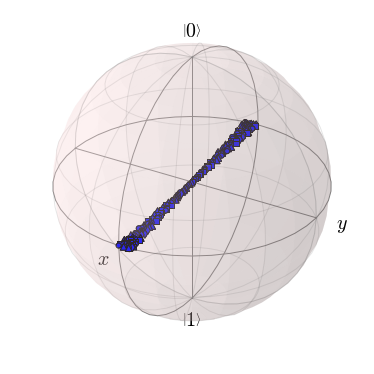

In [50]:
b = qt.Bloch()
b.clear()
b.add_states(rho_nv, kind = 'point')
#b.add_states(rho_nv[-1], kind = 'vector')
b.show()

In [61]:
H = H_full 
rho_nv = []
rho_init_nv_x = qt.tensor(qt.ket2dm((Sz0 + Sz1).unit()), .5 * Ii)
rho = rho_init_nv_x
t = np.mean(tau[1:]-tau[:-1])
t_step = t * 10000
U = (-1j * t_step * H).expm()
rot_freq = delta - gam_el * B_field
for ind in range(200):
    rot_op = qt.tensor((-1j * rot_freq * ind * t_step * Sz), Ii).expm()
    rot_rho = rot_op.dag() * rho * rot_op
    rho_nv.append(qt.Qobj(rot_rho.ptrace(0).full()[:2,:2]))
    rho = U * rho * U.dag()

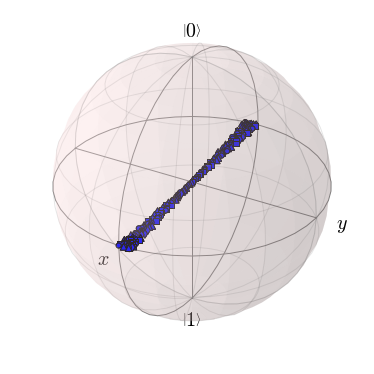

In [62]:
b = qt.Bloch()
b.clear()
b.add_states(rho_nv, kind = 'point')
#b.add_states(rho_nv[-1], kind = 'vector')
b.show()

# The above two bloch spheres show the top two levels of the NV center after being prepared in the +x state and then allowed to evolve in the presence of a spin. The top one is the approximation we make in the paper, the bottom one is the full hamiltonian rotated backwards by delta + omega_S to account for the zero-field splitting and interaction with the B field. For the time scale we use in the actual experiment, they are very close. You can see that for tau on the order of 200 * 10000 * tau_avg = 7452 microseconds, the approximation starts to get a little worse. In the actual experiment, tau only goes up to 22 microseconds. The approximation seems like its good until at least 1000 microseconds for sure.

In [45]:
H = H_full
P = np.zeros(500)
t = np.mean(tau[1:]-tau[:-1])
t_step = t * 10000
taus = []
for ind in range(500):
    t = t_step * ind
    taus.append(t)
    U_tau = (-1j * t * H).expm()
    U = (U_tau * pi_pulse * U_tau) ** N
    rho_final = U * rho_init * U.dag()
    P[ind] = (2 * rho_init * rho_final).tr().real
M = 2 * P - 1
taus = np.array(taus)

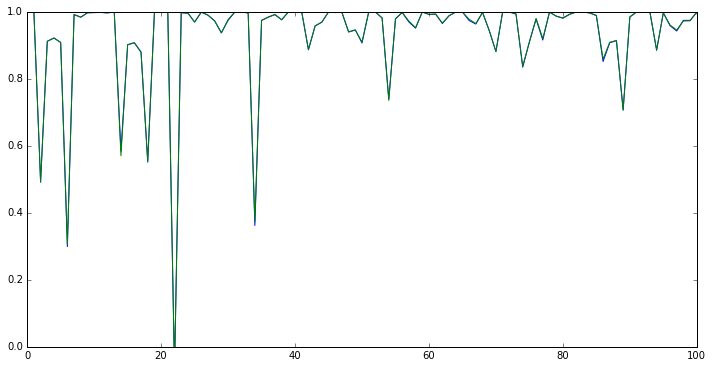

In [48]:
%matplotlib inline
omega_larmor = -1 * gam_c * B_field
fig,ax = analysis.initialize_data_plot(figsize = (12,6), xlims = [0,100], ylims = [0,1])
ax.plot(range(len(taus)), M)
ax.plot(range(len(taus)), analysis.calc_M_single(A, B, N, omega_larmor, taus))

### Indeed you can see that it starts to get a bit off towards the end

In [429]:
H = H_approx 
rho_nv = []
rho_init_nv_x = qt.tensor(qt.ket2dm((Sz0 + Sz1).unit()), .5 * Ii)
rho = rho_init_nv_x
t = np.mean(tau[1:]-tau[:-1])
t_step = t
U = (-1j * t_step * H).expm()
for ind in range(5000):
    rho_nv.append(qt.Qobj(rho.ptrace(0).full()[:2,:2]))
    if ind % 10 == 0:
        rho = pi_pulse * rho * pi_pulse.dag()
    else:
        rho = U * rho * U.dag()

<IPython.core.display.Javascript object>


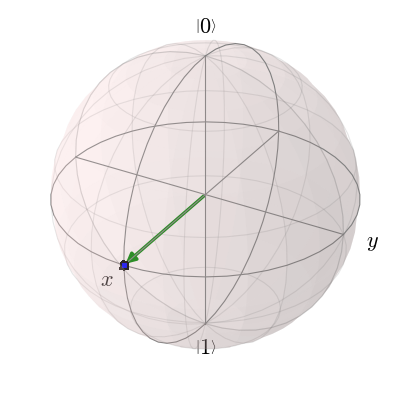

In [430]:
b = qt.Bloch()
b.clear()
b.add_states(rho_nv[:-1], kind = 'point')
b.add_states(rho_nv[-1], kind = 'vector')
b.show()

In [427]:
H = H_full 
rho_nv = []
rho_init_nv_x = qt.tensor(qt.ket2dm((Sz0 + Sz1).unit()), .5 * Ii)
rho = rho_init_nv_x
t = np.mean(tau[1:]-tau[:-1])
t_step = t
U = (-1j * t_step * H).expm()
rot_freq = delta - gam_el * B_field
for ind in range(5000):
    rot_op = qt.tensor((-1j * rot_freq * ind * t_step * Sz), Ii).expm()
    rot_rho = rot_op.dag() * rho * rot_op
    rho_nv.append(qt.Qobj(rot_rho.ptrace(0).full()[:2,:2]))
    if ind % 10 == 0:
        rho = rot_op * pi_pulse * rot_rho * pi_pulse.dag() * rot_op.dag()
    else:
        rho = U * rho * U.dag()

<IPython.core.display.Javascript object>


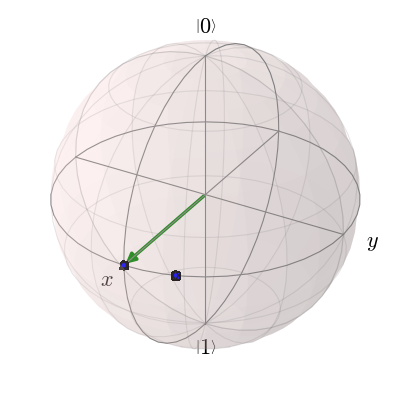

In [428]:
b = qt.Bloch()
b.clear()
b.add_states(rho_nv[:-1], kind = 'point')
b.add_states(rho_nv[-1], kind = 'vector')
b.show()

In [125]:
H = H_approx
rho_cs = []
rho_init_nv_up_c_x = qt.tensor(qt.ket2dm(Sz0), .5 * (Ii + qt.sigmax()))
rho = rho_init_nv_up_c_x
for ind in range(1000):
    if ind % 250 == 0:
        U = pi_pulse
    else:
        U = (-1j * tau[0] * H).expm()
    rho = U * rho * U.dag()
    rho_cs.append(rho.ptrace(1))

<IPython.core.display.Javascript object>


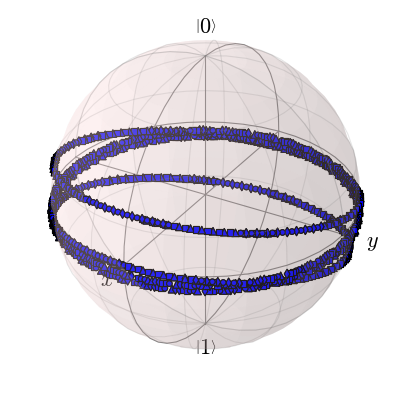

In [126]:
b = qt.Bloch()
b.clear()
b.add_states(rho_cs, kind='point')
b.show()

In [118]:
H = H_full
offset = 5000
tau_large = tau[:1700] + offset * 1e-6
N = 64
P = np.zeros(len(tau_large))
for ind in range(len(tau_large)):
    t = tau_large[ind]
    U_tau = (-1j * t * H).expm()
    U = (U_tau * pi_pulse * U_tau) ** N
    rho_final = U * rho_init * U.dag()
    P[ind] = (2 * rho_init * rho_final).tr().real

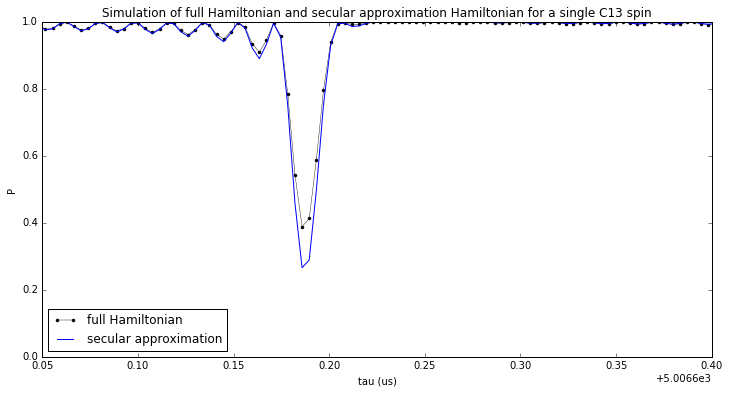

In [139]:
%matplotlib inline
fig,ax = analysis.initialize_data_plot(figsize = (12,6), xlims = [offset+6.65,offset+7], ylims = [0,1])
ax.set_xlabel('tau (us)')
ax.set_ylabel('P')
ax.plot(tau_large * 1e6, P, '.-k', lw=0.4, label = 'full Hamiltonian')
secular_approx_P = .5 * (1+analysis.calc_M_single(A, B, N, omega_larmor, tau_large))
ax.plot(tau_large * 1e6, secular_approx_P, label = 'secular approximation')
plt.title("Simulation of full Hamiltonian and secular approximation Hamiltonian for a single C13 spin")
plt.legend(loc = 3)
#plt.savefig(figures_path + "QuTiP/dynamical_decoupling_t5000us_N64_ms1")

In [143]:
displayed_inds = np.where(np.logical_and(tau_large>=(offset+6.65)*1e-6, tau_large <=(offset+7)*1e-6))[0]
print len(displayed_inds), np.mean(np.abs((P[displayed_inds] - secular_approx_P[displayed_inds])))

94 0.00702300329559


In [142]:
5.35*1e-4

0.000535